<a href="https://colab.research.google.com/github/K-Divyasri/vqa/blob/main/vqa_(3)_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dependencies

In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


- imports

In [2]:
import pandas as pd
from google.colab import drive
import json
from pprint import pprint

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import multiply
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from tqdm import tqdm

- Global configuration variables

In [4]:
BASE_PATH = '/content/drive/Shareddrives/FYP_div' ##
MODEL_PATH = BASE_PATH + "/out/basic_model1.h5"
QUESTION_COUNT = 20
CONVERT_TO_LOWERCASE = True
QUESTIONS_TO_BE_INCLUDED = 18
TEST_SIZE = 0.3
WORD_VECTOR_MODEL = 'glove-wiki-gigaword-300'
IMG_DIMN = 4096
BATCH_SIZE = 8
EPOCHS = 15
LR = 0.001
DEMO_COUNT = 15
USE_CHECKPOINT=False

def sync_gdrive(init=False):
  if not init: drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=init)

sync_gdrive(init=True)

Mounted at /content/drive


- Downloading the dataset (Run only once)

In [5]:
### Downloading ImageCLEF Dataset

# !gdown 1jTyLWwcHzbLpWjSNwmgiiavXDjuQe5y7 # Development dataset
# !gdown 1PQPiOkyfQrLJ5wWxkHZy_FYIdL9hXiMl # Testing dataset

# !unzip ImageCLEF\*
# !rm -rf *.zip

# !mkdir $BASE_PATH/dataset
# !mkdir -p $BASE_PATH/out/trial1
# !mv ImageCLEF* $BASE_PATH/dataset

# !mv $BASE_PATH/dataset/*Dev* $BASE_PATH/dataset/dev
# !mv $BASE_PATH/dataset/*Test* $BASE_PATH/dataset/test

# sync_gdrive()

In [6]:
with open(BASE_PATH + '/dataset/dev/gt.json', "r") as json_file:
    gt = json.load(json_file)

Based on below data analysis, 2 data points do not make sense. The below code-block has been edited to exclude these 2 images.

- `cl8k2u1rr1gm30832fz9x3vru`  
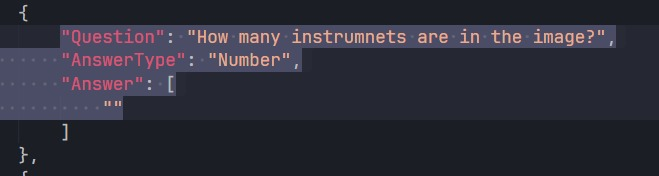

- `clb0lbwzddp1s086uh1e2gw0y`  
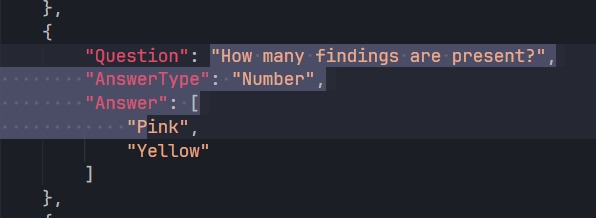

In [7]:
INCORRECT_DATAPOINTS = ['clb0lbwzddp1s086uh1e2gw0y', 'cl8k2u1rr1gm30832fz9x3vru']

def convert_img_data(img):
  if not CONVERT_TO_LOWERCASE: return img

  for label in img['Labels']:
    label['Question'] = label['Question'].lower()
    label['AnswerType'] = label['AnswerType'].lower()
    label['Answer'] = [ans.lower() for ans in label['Answer']]
  return img

gt = [convert_img_data(img) for img in gt if img['ImageID'] not in INCORRECT_DATAPOINTS]

- Dataset Analysis
- **Note**: The question IDs here DO NOT correspond to the IDs in the dataset's [README](https://github.com/simula/ImageCLEFmed-MEDVQA-GI-2023#task-1-visual-question-answering-vqa)

In [8]:
GT = {
    'question': [],
    'answer_count': [0 for _ in range(QUESTION_COUNT)],
    'answer_type': ['' for _ in range(QUESTION_COUNT)],
    'is_multi_answer': [False for _ in range(QUESTION_COUNT)],
    'possible_answers': [[] for _ in range(QUESTION_COUNT)]
}

for img in gt:
  for label in img['Labels']:
    q = label['Question']
    at = label['AnswerType']
    a = label['Answer']

    if not q in GT['question']: GT['question'].append(q)
    ix = GT['question'].index(q)
    if GT['is_multi_answer'][ix] is False and len(a) > 1: GT['is_multi_answer'][ix] = True
    if len(a) != 1 or a[0].lower() != 'not relevant': GT['answer_count'][ix] += 1
    GT['answer_type'][ix] = at
    if at.lower() == 'segmentation':
      GT['possible_answers'][ix] = 'any mask' # TODO: Fix this
    else:
      GT['possible_answers'][ix] += a
      GT['possible_answers'][ix] = list(set(GT['possible_answers'][ix]))

GT = pd.DataFrame(GT)

GT = GT.sort_values(by='answer_count', ascending=False)
GT = GT.sort_values(by='possible_answers', key=lambda x: x.str.len())
GT = GT.sort_values(by='answer_type', key=lambda x: x.eq('segmentation'))
GT = GT.reset_index(drop=True)

GT

,question,answer_count,answer_type,is_multi_answer,possible_answers
0,is there text?,1998,yes/no,False,"[yes, no]"
1,where in the image is the anatomical landmark?,522,text,True,"[upper-left, upper-center, lower-rigth, center..."
2,where in the image is the instrument?,555,text,True,"[lower-right, upper-center, upper-left, center..."
3,how many findings are present?,1998,number,False,"[2, 4, 0, 1, 6, 5, 16, 3]"
4,how many polyps are in the image?,1998,number,False,"[2, 4, 0, 1, 6, 5, 16, 3]"
5,what color is the anatomical landmark?,88,text,True,"[grey, brown, red, not relevant, yellow, white..."
6,are there any instruments in the image?,1014,text,True,"[tube, biopsy forceps, polyp snare, not releva..."
7,where in the image is the abnormality?,1613,text,True,"[lower-right, upper-left, upper-center, center..."
8,are there any anatomical landmarks in the image?,1566,text,False,"[z-line, ileum, not relevant, cecum, no, pylorus]"
9,are there any abnormalities in the image?,1998,text,True,"[oesophagitis, barretts, ulcerative colitis, p..."


- Combining questions

In [9]:
# TODO: Combine similar questions here

- Vectoring the images using VGG (Run only once) - Follow [this](https://medium.com/@rajeshmane711/visual-question-answering-system-using-deep-learning-techniques-5636a9c6b72d) article

In [10]:


# # Load ResNet50 model with pre-trained weights on ImageNet
# model = ResNet50(weights='imagenet')
# # Remove the final classification layer
# feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# def parse_function(filename):
#     image_string = tf.io.read_file(filename)
#     image = tf.image.decode_jpeg(image_string, channels=3)
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, [224, 224])  # Assuming ResNet50 input size
#     return image, filename



# img_fl = sorted(set([f"{BASE_PATH}/dataset/dev/images/{img['ImageID']}.jpg" for img in gt]))
# print(len(img_fl))
# img_data_tr = tf.data.Dataset.from_tensor_slices(img_fl)
# img_data_tr = img_data_tr.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# for img, path in tqdm(img_data_tr):
#     batch_features = feature_model(img)

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         path_of_feature = path_of_feature.replace("dataset/dev/images", "out/trial1").replace(".jpg", "")
#         np.save(path_of_feature, bf.numpy())


# sync_gdrive()


In [11]:
# model = VGG16(weights='imagenet')
# feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# def parse_function(filename):
#     image_string = tf.io.read_file(filename)
#     #Don't use tf.image.decode_image, or the output shape will be undefined
#     image = tf.image.decode_jpeg(image_string, channels=3)
#     #This will convert to float values in [0, 1]
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, [224, 224])
#     return  image, filename

# img_fl = sorted(set([f"{BASE_PATH}/dataset/dev/images/{img['ImageID']}.jpg" for img in gt]))
# img_data_tr = tf.data.Dataset.from_tensor_slices(img_fl)
# img_data_tr = img_data_tr.map(parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# for img, path in tqdm(img_data_tr):
#   batch_features = feature_model(img)
#   #batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     path_of_feature = path_of_feature.replace("dataset/dev/images", "out/trial1").replace(".jpg", "")
#     np.save(path_of_feature, bf.numpy())

# sync_gdrive()

- Creating and splitting the dataset

In [12]:
questions_to_include = GT['question'][:QUESTIONS_TO_BE_INCLUDED].tolist()
# possible_answers = {q: GT.loc[GT['question'] == q, 'possible_answers'].values[0] for q in questions_to_include}
# possible_answers = [element for row in possible_answers.values() for element in row]

dataset = {
    'image': [],
    'question': [],
    'answer': []
}

for img in gt:
  for label in img['Labels']:
    if label['Question'] not in questions_to_include: continue

    dataset['image'].append(img['ImageID'])
    dataset['question'].append(label['Question'])
    dataset['answer'].append(','.join(label['Answer'])) # Join answers

dataset = pd.DataFrame(dataset)

X = dataset[['question', 'image']]
y = dataset['answer']

print(f"Before Split - {len(X)}, {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=42)

print(f"Train - {len(X_train)}, {len(y_train)}")
print(f"TEst - {len(X_test)}, {len(y_test)}")

Before Split - 35964, 35964
Train - 25174, 25174
TEst - 10790, 10790


- Vectorizing the questions

In [13]:
import gensim.downloader as api
glove_model = api.load(WORD_VECTOR_MODEL)

max_length = GT['question'].str.len().max()

def textokenizer(text):
  tok = Tokenizer()
  tok.fit_on_texts(X_train['question'])
  vocab_size = len(tok.word_index) + 1
  print('Total unique words in the X_train',vocab_size)
  encoded_text = tok.texts_to_sequences(text)
  padded_text = pad_sequences(encoded_text, maxlen=max_length)  #padding zeros at the begining of each question so \
                                                                #that each sequence will have same length
  return padded_text, tok

# for train
padded_text, tok = textokenizer(X_train['question'])
vocab_size = len(tok.word_index) + 1
embedding_matrix_train = np.zeros((vocab_size, 300))
for word, i in tok.word_index.items():
    if word in glove_model:
        embedding_vector = glove_model[word]
        embedding_matrix_train[i] = embedding_vector

[==================================================] 100.0% 376.1/376.1MB downloaded
Total unique words in the X_train 46


- One hot encoding

In [14]:
def optokens(classes):
  from sklearn.preprocessing import OneHotEncoder
  ohe=OneHotEncoder(handle_unknown='ignore')
  ohe.fit(y_train.values.reshape(-1,1))
  optoken=ohe.transform(classes.values.reshape(-1,1)).toarray()
  return optoken, ohe

_,ohe=optokens(y_train)

- Vectorize the dataset

In [15]:
ques_train , _ =textokenizer(X_train['question'])
answ_train , _ =optokens(y_train)

ques_train=ques_train.tolist()
answ_train=answ_train.tolist()


ques_test,_=textokenizer(X_test['question'])
answ_test,_=optokens(y_test)

ques_test=ques_test.tolist()
answ_test=answ_test.tolist()

Total unique words in the X_train 46
Total unique words in the X_train 46


- Combining images and questions

In [16]:
def map_func(img_name, question):
  img_tensor = np.load(BASE_PATH + '/out/trial1/' + img_name.decode('utf-8') + '.npy')
  return img_tensor, question

def map_main_fn(item1, item2):
  return tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32])

def shape(a, b):
  a.set_shape(IMG_DIMN)
  b.set_shape(max_length)
  return a,b

img_fl = X_train['image'].tolist()
train_dataset = tf.data.Dataset.from_tensor_slices((img_fl, ques_train))


# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(map_main_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(shape)
op_train_dataset = tf.data.Dataset.from_tensor_slices(answ_train)
train_dataset = tf.data.Dataset.zip((train_dataset,op_train_dataset))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

img_fl_te = X_test['image'].tolist()
test_dataset = tf.data.Dataset.from_tensor_slices((img_fl_te, ques_test))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(map_main_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(shape)
op_test_dataset = tf.data.Dataset.from_tensor_slices(answ_test)
test_dataset = tf.data.Dataset.zip((test_dataset,op_test_dataset))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

- Creating the fusion model

In [17]:
from tensorflow.keras.regularizers import l2
#IMAGE MODEL
im_input = Input(shape=(4096,), name = "im_input")
#flat = Flatten()(im_input)
image_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(im_input)
image_model=Model(inputs=im_input,outputs=image_model)
image_model.summary()

#QUESTION MODEL
ques_input = Input(shape=(max_length,), name = "ques_input")
e1 =Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=max_length,trainable=False)(ques_input)
l1= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(e1)
l2= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(l1)
#l1= LeakyReLU(alpha = 0.3)(l1)
f1= Flatten(name='flatten_1')(l2)
question_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(f1)
question_model = Model(inputs=ques_input, outputs=question_model)
question_model.summary()

#COMBINING FEATURES AND MAKING FINAL MODEL FOR PREDICTION
input_model=multiply([image_model.layers[-1].output,question_model.layers[-1].output])
d1=BatchNormalization()(input_model)
d1 = Dropout(0.5)(d1)
d1=Dense(1000,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(d1)
final_output = Dense(op_train_dataset.element_spec.shape[0], kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(d1)
final_model = Model(inputs=[im_input,ques_input], outputs=final_output)
print(final_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 im_input (InputLayer)       [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4195328   
                                                                 
Total params: 4195328 (16.00 MB)
Trainable params: 4195328 (16.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ques_input (InputLayer)     [(None, 53)]              0         
                                                                 
 embedding (Embedding)       (None, 53, 300)           13800     
                                                                 
 lst

- Training

In [18]:
len(train_dataset)

3147

In [19]:
len(test_dataset)

1349

In [21]:
checkpoint = ModelCheckpoint(MODEL_PATH,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
earlystop= EarlyStopping(monitor = 'val_loss',
                            mode="min",
                            min_delta = 0,
                            patience = 10,
                            verbose = 1)

tensorboard = TensorBoard(log_dir='logs1',histogram_freq=1,write_grads=True)
callbacks = [checkpoint,earlystop,tensorboard]

if USE_CHECKPOINT: final_model=load_model(MODEL_PATH)
else:
    final_model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    final_model.summary()

    # Take a single batch for inspection
    for img, label in train_dataset.take(1):
        # Print the shapes of input data
        #print("Input Image Shape:", img.shape)
        print("Input Label Shape:", label.shape)

        # Make predictions on the training batch
        predictions = final_model.predict(img)

        # Print the shape of the model predictions
        print("Model Predictions Shape:", predictions.shape)

    # Train the model
    h1 = final_model.fit(train_dataset, epochs=EPOCHS-5, verbose=1, callbacks=callbacks, validation_data=test_dataset)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ques_input (InputLayer)     [(None, 53)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 53, 300)              13800     ['ques_input[0][0]']          
                                                                                                  
 lstm (LSTM)                 (None, 53, 64)               93440     ['embedding[0][0]']           
                                                                                                  
 lstm_1 (LSTM)               (None, 53, 64)               33024     ['lstm[0][0]']                
                                                                                            

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes at component 0: expected [?,4096] but got [8,2048]. [Op:IteratorGetNext] name: 

- function to run the trained model for a given input

In [ ]:
def predict_answer(filename,question,answer):
  def textokenizer(text):
     text=[text]
     encoded_text = tok.texts_to_sequences(text)
     padded_text = pad_sequences(encoded_text, maxlen=max_length)  #padding zeros at the begining of each question so that each sequence will have same length
     return  padded_text

  def optokens(answer):
     global ohe
     answer=np.array(answer,dtype=object)
     #ohe=pickle.load(open('/content/drive/My Drive/ohe.pkl','rb'))
     optoken=ohe.transform(answer.reshape(-1,1)).toarray()
     return optoken, ohe

  def parse_function(filename):
    image_string = tf.io.read_file(BASE_PATH + '/dataset/dev/images/' + filename  + '.jpg')
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    plt.imshow(image)
    image =tf. expand_dims(image, axis=0)
    return  image, filename

  model = ResNet50(weights='imagenet')
  feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  image,_=parse_function(filename)
  image_feature = feature_model(image)
  question_feature = textokenizer(question)
 # answer_feature,_ = optokens(answer)
  answer_vector = final_model.predict([image_feature,question_feature])
  _,ohe=optokens(answer)
  predicted_answer=ohe.inverse_transform(answer_vector)
  predicted_answer=predicted_answer.tolist()[0][0]
  return predicted_answer

- Demo

In [ ]:
inputs = X_test.sample(n=DEMO_COUNT)
actual_outputs = y_test.loc[inputs.index]

plt.figure(figsize=(40, 20))
plt.tight_layout()
columns = 3

for i, (index, input) in enumerate(inputs.iterrows()):
  predicted_ans = predict_answer(input['image'], input['question'], actual_outputs.loc[index])

  plt.subplot(DEMO_COUNT // columns + 1, columns, i + 1)
  img = mpimg.imread(BASE_PATH + '/dataset/dev/images/' + input['image']  + '.jpg')
  plt.imshow(img)
  plt.title(f"Question: {input['question']}\nActual answer: {actual_outputs.loc[index]}\nPredicted answer: {predicted_ans}")

plt.show()